In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import boxcox
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest,chi2, SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

## 1. Reading and understanding the data.

In [6]:
# Creating function to display shape and columns in the dataset

def displaycolumns(data):
    column_list = []
    for col in data.columns:
        column_list.append(col)
    print(f"The dimensions of the dataset: {data.shape}")
    print(f"The columns in the dataset: {column_list}")

### Loading data

In [7]:
# Reading the data and understanding the shape, columns and top datasets.

data_raw = pd.read_csv("DataSet_PCP_Change.csv", index_col = "testindex")

displaycolumns(data_raw)

The dimensions of the dataset: (3130, 13)
The columns in the dataset: ['outcome', 'distance', 'visit_count', 'claims_daysaway', 'tier', 'fqhc', 'pcp_lookback', 'family_assignment', 'kid', 'is_ped', 'same_gender', 'same_language', 'same_address']


In [8]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3130 entries, 0 to 5000
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   outcome            3130 non-null   int64  
 1   distance           3130 non-null   float64
 2   visit_count        3130 non-null   int64  
 3   claims_daysaway    556 non-null    float64
 4   tier               3121 non-null   float64
 5   fqhc               3130 non-null   int64  
 6   pcp_lookback       3130 non-null   int64  
 7   family_assignment  3130 non-null   int64  
 8   kid                3130 non-null   int64  
 9   is_ped             3130 non-null   int64  
 10  same_gender        3130 non-null   int64  
 11  same_language      3130 non-null   int64  
 12  same_address       3130 non-null   int64  
dtypes: float64(3), int64(10)
memory usage: 342.3 KB


##### Observations - 
        1. The dataset has 3130 entries of 13 attributes (including response - "outcome").
        2. Information analysis above shows that "claims_daysaway" (556 entries) and "tier" (3121 entries) are the attributes with missing data.

### Data Quality - Missing data identification and imputation

In [9]:
# Getting the number and % of missing values for "claims_daysaway" and "tier" attributes.

print(data_raw.isnull().sum())

outcome                 0
distance                0
visit_count             0
claims_daysaway      2574
tier                    9
fqhc                    0
pcp_lookback            0
family_assignment       0
kid                     0
is_ped                  0
same_gender             0
same_language           0
same_address            0
dtype: int64


In [10]:
for col in data_raw.columns:
    per_missing = round((data_raw[col].isnull().sum()/len(data_raw))*100, 2)
    print(f"The '{col}' attribute has {per_missing} % missing data.")

The 'outcome' attribute has 0.0 % missing data.
The 'distance' attribute has 0.0 % missing data.
The 'visit_count' attribute has 0.0 % missing data.
The 'claims_daysaway' attribute has 82.24 % missing data.
The 'tier' attribute has 0.29 % missing data.
The 'fqhc' attribute has 0.0 % missing data.
The 'pcp_lookback' attribute has 0.0 % missing data.
The 'family_assignment' attribute has 0.0 % missing data.
The 'kid' attribute has 0.0 % missing data.
The 'is_ped' attribute has 0.0 % missing data.
The 'same_gender' attribute has 0.0 % missing data.
The 'same_language' attribute has 0.0 % missing data.
The 'same_address' attribute has 0.0 % missing data.


##### Since "claims_daysaway" has ~82 % missing  data, so this attribute will be dropped for further analysis. However, the "tier" attribute, which a categorical variable, has only 0.29 % missing data and thus will be considered with "mode imputation" method to replace the missing information.

In [11]:
data = data_raw.drop(["claims_daysaway"], axis = 1)
data["tier"] = data["tier"].fillna(data["tier"].mode()[0])

displaycolumns(data)

The dimensions of the dataset: (3130, 12)
The columns in the dataset: ['outcome', 'distance', 'visit_count', 'tier', 'fqhc', 'pcp_lookback', 'family_assignment', 'kid', 'is_ped', 'same_gender', 'same_language', 'same_address']


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3130 entries, 0 to 5000
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   outcome            3130 non-null   int64  
 1   distance           3130 non-null   float64
 2   visit_count        3130 non-null   int64  
 3   tier               3130 non-null   float64
 4   fqhc               3130 non-null   int64  
 5   pcp_lookback       3130 non-null   int64  
 6   family_assignment  3130 non-null   int64  
 7   kid                3130 non-null   int64  
 8   is_ped             3130 non-null   int64  
 9   same_gender        3130 non-null   int64  
 10  same_language      3130 non-null   int64  
 11  same_address       3130 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 317.9 KB


## 2. Data preprocessing.

In [13]:
# Identifying the categorical variables through unique values.

unique_counts = pd.DataFrame.from_records([(col, data[col].nunique()) for col in data.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])

print(unique_counts)

          Column_Name  Num_Unique
0             outcome           2
4                fqhc           2
5        pcp_lookback           2
6   family_assignment           2
7                 kid           2
8              is_ped           2
9         same_gender           2
10      same_language           2
11       same_address           2
3                tier           4
2         visit_count          31
1            distance        3090


##### Above output shows that "tier" and "visit_count" attributes have 4 and 31 unique values respectively. Rest all the other attributes (including response attribute "outcome") are binary in nature.

### Imbalance / Skewness identification in the dataset

The skewness information:
distance             4.876756
visit_count          4.778858
outcome              4.659267
same_language        3.535541
same_address         3.514287
fqhc                 1.561988
tier                 0.903941
family_assignment    0.667141
kid                  0.507856
is_ped               0.441229
pcp_lookback         0.232984
same_gender         -0.047320
dtype: float64


array([[<AxesSubplot:title={'center':'outcome'}>,
        <AxesSubplot:title={'center':'distance'}>,
        <AxesSubplot:title={'center':'visit_count'}>],
       [<AxesSubplot:title={'center':'tier'}>,
        <AxesSubplot:title={'center':'fqhc'}>,
        <AxesSubplot:title={'center':'pcp_lookback'}>],
       [<AxesSubplot:title={'center':'family_assignment'}>,
        <AxesSubplot:title={'center':'kid'}>,
        <AxesSubplot:title={'center':'is_ped'}>],
       [<AxesSubplot:title={'center':'same_gender'}>,
        <AxesSubplot:title={'center':'same_language'}>,
        <AxesSubplot:title={'center':'same_address'}>]], dtype=object)

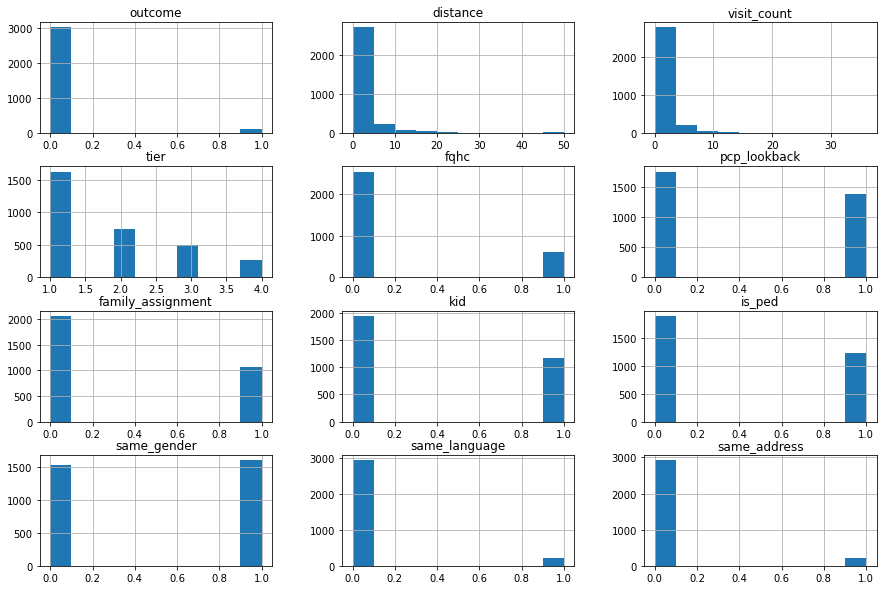

In [14]:
# Further, data visualization for distribution, shape, size and skewness.

# Skewnewss check
print("The skewness information:")
print(data.skew().sort_values(ascending = False))

# Distribution check
data.hist(figsize = (15, 10))

##### Observations -
        1. The "outcome" (response) variable, which is a categorical variable with 2 entries, is highly imbalanced (positive skewness > 4) with more number of 0 (i.e. representing the member who keeps the auto assigned provider) label than 1 label (i.e. represenging the member who changed to different provider by calling customer service).
        2. The "distance" attribute, which is a continous variable, has entries which are right skewed (positive skewness > 4).
        a. For such righly skewed distributed attributes logarithmic transformation can be used.
        3. The "visit_count" attribute, which is a discrete type continous variable (because of many entries), has entries which are right skewed (positive skewness > 4).
        a. For such righly skewed distributed attributes logarithmic transformation can be used.
        4. The "tier" attribute, which is a ordinal (categorical) variable with 4 entries, is fairly distributed with slightly more entires towards 1 which represents the highest benefit level and most cost-effective level. This shows that more number of people prefer label 1 over label 2, label 2 over label 3 and label 3 over label 4.
    5. The "fqhc", "same_language" and "same_address" attributes, which are binary variables, too are highly imbalanced.
    6. Rest of the attributes are binary variables and are fairly balanced.

##### * If the response variable is skewed/imbalanced categorical classes (say label 0 of "outcome" in our case), and if the values of the independent variable (feaature) are also skewed, depending on the model, skewness may violate model assumptions (e.g. logistic regression) or may impair the interpretation of feature importance. Therefore, it is important to perform feature engineering through transformation in order to reduce the skewness. 

### Skewness reduction - continuous variable

In [15]:
# Working on the skewness of the continuous variables "distance" and "visit_count" through log transformation.
data_transformed = data.copy(deep = True)

data_transformed.distance = data_transformed.distance.map(lambda x: np.log(x+1))
data_transformed.visit_count = data_transformed.visit_count.map(lambda x: np.log(x+1))

print("The skewness information after transformation:")
print(data_transformed[["distance", "visit_count"]].skew().sort_values(ascending = False))

The skewness information after transformation:
visit_count    2.154438
distance       1.484972
dtype: float64


C:\Users\ch065ba\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


C:\Users\ch065ba\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


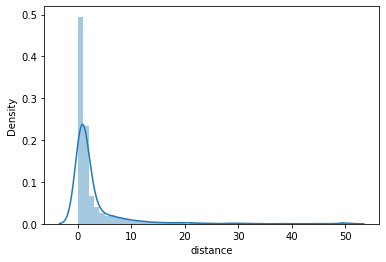

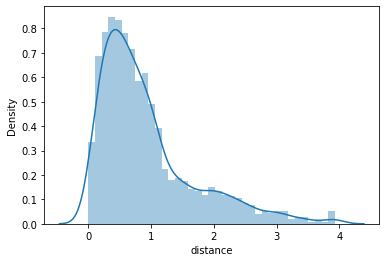

In [16]:
# Check before and after distribution of the "distance" attribute.

plt.figure()
print(sns.distplot(data.distance))
plt.figure()
print(sns.distplot(data_transformed.distance))

C:\Users\ch065ba\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ch065ba\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


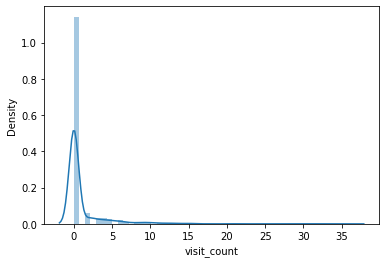

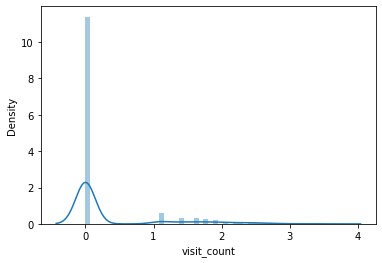

In [17]:
# Check before and after distribution of the "visit_count" attribute.

plt.figure()
print(sns.distplot(data.visit_count))
plt.figure()
print(sns.distplot(data_transformed.visit_count))

##### * After log-transformation, the skewness has been reduced to a significant figure. Though, for better result box-cox transformation could be used, considering the moderate skewness achieved through log-transformation, these transformed values will be used for further analysis.

In [18]:
# def boxcoxtransformation(data, col):
#     data_col_name = data[col]
#     data_col_name_segg = data_col_name[col][data_col_name[col] > 0]
#     bcdata, lam = boxcox(data_col_name_segg)
#     x = np.empty_like(data_col_name)
#     x[data_col_name > 0] = bcdata
#     x[data_col_name == 0] = -1/lam
#     pd.concat([data, x], axis=1)
#     return data

### Correlation analysis

In [19]:
# Analysing the correlation coefficient to identify the correlation among different independent/dependent variables.

# Creating correlation 
corr = data_transformed.corr()

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,outcome,distance,visit_count,tier,fqhc,pcp_lookback,family_assignment,kid,is_ped,same_gender,same_language,same_address
outcome,1.00,0.11,0.09,0.01,-0.03,-0.09,0.01,0.05,0.00,-0.00,-0.03,0.08
distance,0.11,1.00,0.09,0.05,-0.05,0.19,0.03,0.03,0.01,0.03,-0.02,0.01
visit_count,0.09,0.09,1.00,0.07,-0.13,0.30,0.14,0.12,0.09,0.03,-0.02,0.04
tier,0.01,0.05,0.07,1.00,-0.15,0.08,0.01,-0.01,-0.03,0.01,-0.05,0.05
fqhc,-0.03,-0.05,-0.13,-0.15,1.00,-0.12,-0.08,-0.04,-0.04,0.01,0.04,0.05
pcp_lookback,-0.09,0.19,0.30,0.08,-0.12,1.00,0.09,0.09,0.08,0.02,-0.02,0.10
family_assignment,0.01,0.03,0.14,0.01,-0.08,0.09,1.00,0.31,0.30,-0.03,0.03,0.01
kid,0.05,0.03,0.12,-0.01,-0.04,0.09,0.31,1.00,0.88,-0.02,-0.02,-0.02
is_ped,0.00,0.01,0.09,-0.03,-0.04,0.08,0.30,0.88,1.00,-0.00,0.01,-0.01
same_gender,-0.00,0.03,0.03,0.01,0.01,0.02,-0.03,-0.02,-0.00,1.00,0.26,-0.01


##### Observations - 
        1. From the correlation map above, it is very obvious that the "kid" and "is_ped" variables are highly correlated. This could be mainly because, for the kids, the automatically assigned doctoro will be a pediatrician. Therefore, one of these variables can be dropped. Therefore, the "kid" attribute will be dropped for further analysis.

In [20]:
data_transformed = data_transformed.drop(["kid"], axis = 1)
displaycolumns(data_transformed)

The dimensions of the dataset: (3130, 11)
The columns in the dataset: ['outcome', 'distance', 'visit_count', 'tier', 'fqhc', 'pcp_lookback', 'family_assignment', 'is_ped', 'same_gender', 'same_language', 'same_address']


### Outlier identification and removal - continuous variable

<AxesSubplot:>

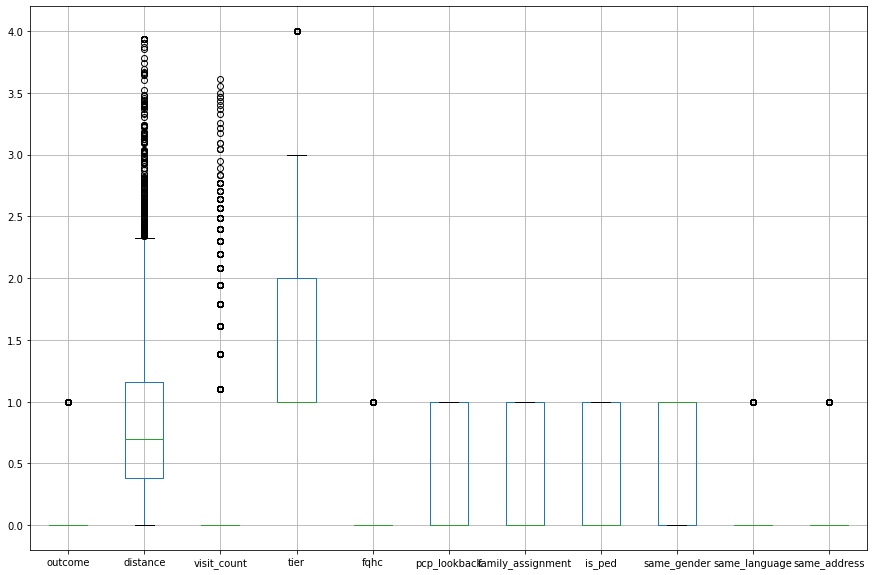

In [21]:
# Creating the box-plot to check outlier in the data.

data_transformed.boxplot(figsize = (15, 10))

##### * Since the dataset are slightly righ-skewed, instead of 1.5*IQR, > 3 times Standard Deviation method will be used to identify the outlier.

In [22]:
# Creating a function to detect outlier in the dataset

def detect_outlier(data, col):
  mean = np.mean(data[col])
  stddev = np.std(data[col])
  indices = []
  for index,value in data[col].iteritems():
    z_score = (value-mean)/stddev
    if abs(z_score) > 3:
      indices.append(index)
  return indices

In [23]:
# Identifying and dropping the outliers.

outliers_distance = detect_outlier(data_transformed,"distance")
outliers_visit_count = detect_outlier(data_transformed,"visit_count")
data_transformed.drop(outliers_distance,inplace=True)

#Drop the indices that are common for both the outliers

outlier_visit_count = [index for index in outliers_visit_count if index not in outliers_distance] 
data_transformed.drop(outlier_visit_count,inplace=True)

print(data_transformed.shape)

(3007, 11)


### Data discretization

In [24]:
# This step is to discretize and encode the continuous variable into certain classes.

# Identifying the continuous and categorical features -
data_transformed2 = data_transformed.copy(deep = True)

report = {}
report["var_names"] = []
report["var_type"] = []

for col in data_transformed2.columns:
    if len(data_transformed2[col].unique()) < 5:
        report["var_names"].append(col)
        report["var_type"].append("Categorical")
    else:
        report["var_names"].append(col)
        report["var_type"].append("Continuous")
    
print(pd.DataFrame(report))

# Discretization of continuous features -
discretizer = KBinsDiscretizer(n_bins = 5, encode = 'ordinal', strategy = 'uniform')

data_transformed2["distance"] = discretizer.fit_transform(data_transformed2[["distance"]])
data_transformed2["visit_count"] = discretizer.fit_transform(data_transformed2[["visit_count"]])

            var_names     var_type
0             outcome  Categorical
1            distance   Continuous
2         visit_count   Continuous
3                tier  Categorical
4                fqhc  Categorical
5        pcp_lookback  Categorical
6   family_assignment  Categorical
7              is_ped  Categorical
8         same_gender  Categorical
9       same_language  Categorical
10       same_address  Categorical


In [25]:
# Identifying the number of labels after discretization.

unique_counts = pd.DataFrame.from_records([(col, data_transformed2[col].nunique()) for col in data_transformed2.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])

print(unique_counts)

          Column_Name  Num_Unique
0             outcome           2
4                fqhc           2
5        pcp_lookback           2
6   family_assignment           2
7              is_ped           2
8         same_gender           2
9       same_language           2
10       same_address           2
2         visit_count           4
3                tier           4
1            distance           5


##### After discretization, the "distance" and the "visit_count" attributes are also converted into categorical with 5 and 4 labels respectively. The five labels of distance attribute represents near, very near, reachable, far, very far. The four lables of "visit_count" represents low, medium, high and very high visit counts. 

In [26]:
print("The 'distance' attribute values before discretization: ", pd.unique(data_transformed.distance))
print("The 'distance' attribute values after discretization: ", pd.unique(data_transformed2.distance))
print("The 'visit_count' attribute values before discretization: ", pd.unique(data_transformed.visit_count))
print("The 'visit_count' attribute values after discretization: ", pd.unique(data_transformed2.visit_count))
print("The 'tier' attribute values: ", pd.unique(data_transformed.tier))

The 'distance' attribute values before discretization:  [0.06944404 0.37049229 0.29698335 ... 0.89492379 0.495494   2.56087143]
The 'distance' attribute values after discretization:  [0. 1. 3. 2. 4.]
The 'visit_count' attribute values before discretization:  [0.         1.79175947 1.60943791 2.30258509 2.07944154 1.94591015
 1.09861229 1.38629436 2.39789527 2.19722458]
The 'visit_count' attribute values after discretization:  [0. 3. 4. 2.]
The 'tier' attribute values:  [2. 1. 3. 4.]


In [27]:
data_transformed2

,outcome,distance,visit_count,tier,fqhc,pcp_lookback,family_assignment,is_ped,same_gender,same_language,same_address
testindex,,,,,,,,,,,
0,0,0.0,0.0,2.0,0,0,0,0,1,0,0
2,0,0.0,0.0,1.0,0,0,1,1,0,0,0
5,0,0.0,0.0,1.0,0,1,0,0,1,0,0
6,0,1.0,0.0,1.0,0,0,1,1,1,0,0
7,1,3.0,0.0,1.0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4991,0,1.0,0.0,1.0,0,1,1,1,0,0,0
4992,0,0.0,0.0,1.0,0,0,0,0,1,0,0
4994,0,1.0,0.0,3.0,0,1,0,0,1,0,1


### Data transformation - min-max normalization (0 to 1)

In [28]:
# In order to have more stable and accurate model-generation, it is important to scale the variables in order to make 
# the problem easier to learn.

data_transformed3 = data_transformed2.copy(deep = True)

scaler = MinMaxScaler(feature_range = (0, 1))

data_transformed3[["visit_count", "tier", "distance"]] = scaler.fit_transform(data_transformed2[["visit_count", "tier", "distance"]])

In [29]:
data_transformed3[["visit_count", "tier", "distance"]].head(10)

,visit_count,tier,distance
testindex,,,
0,0.00,0.333333,0.00
2,0.00,0.000000,0.00
5,0.00,0.000000,0.00
6,0.00,0.000000,0.25
7,0.00,0.000000,0.75
9,0.00,0.333333,0.50
10,0.00,0.000000,0.25
11,0.00,0.000000,0.50
13,0.00,0.000000,0.75


## 3. Model training

### Models selected for the problem

##### The following models are selected to be evaluated
        1. Logistic Regression
        2. Decision Tree based method
        3. k-nearest Neighbors
        4. Naïve Bayes
        5. Support Vector Machine

In [30]:
# SPlit-out test train data

array = data_transformed2.values
X = array[:,1:11]
Y = array[:,0]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1)

##### Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set (i.e. dividing the dataset into train and test sets).

##### When evaluating different settings (“hyperparameters”) for estimators, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

##### However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

##### A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets. The following procedure is followed for each of the k “folds”:

###### 1. A model is trained using  of the folds as training data;

###### 2. the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

##### The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.

##### In our classification problem, there is a large imbalance in the distribution of the target classes. In such cases it is recommended to use stratified sampling as implemented in StratifiedKFold to ensure that relative class frequencies is approximately preserved in each train and validation fold.

In [31]:
# Spot Check Algorithm
models = []
models.append(("LR", LogisticRegression(solver = "liblinear", multi_class = "auto")))
models.append(("CART", DecisionTreeClassifier(criterion = "gini", splitter = "best", 
                                              max_depth = None, min_samples_split = 2, min_samples_leaf = 1)))
models.append(("KNN", KNeighborsClassifier(n_neighbors = 5, weights = "uniform", algorithm = "auto",
                                leaf_size = 30, p = 2, metric = "minkowski")))
models.append(("NB-G", GaussianNB()))
# models.append(("NB-B", BernoulliNB()))
# models.append(("SVM-SVC", SVC(gamma = "auto")))
models.append(("SVM-LSVC", LinearSVC()))

# Evaluate each model in turn
results = []
names = []
for name, model in models:
    rskf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 11)
    cv_results = cross_val_score(model, X_train, Y_train, cv = rskf, scoring = "accuracy")
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

LR: 0.962453 (0.001407)
CART: 0.948379 (0.011886)
KNN: 0.963118 (0.003088)
NB-G: 0.896353 (0.116208)


C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of 

SVM-LSVC: 0.962453 (0.001407)


C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


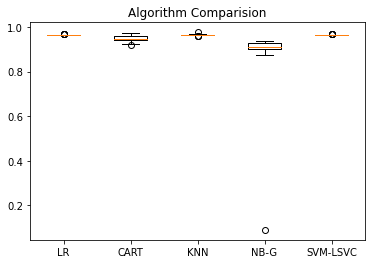

In [32]:
plt.boxplot(results, labels = names, notch = False, vert = True, whis = True)
plt.title("Algorithm Comparision")
plt.show()

In [33]:
# Train Dataset balance study
print("Response counts of label '0': {}".format(sum(Y_train == 0)))
print("Response counts of label '1': {}".format(sum(Y_train == 1)))
# (round(sum(Y_train == 1) / (sum(Y_train == 0) + sum(Y_train == 1)),2))*100

Response counts of label '0': 2025
Response counts of label '1': 79


##### As observed  above, the dataset is highly unbalanced. When training models on such datasets, class unbalance influences a learning algorithm during training by making decision rule biased towards the majority class and optimizes the predictions based on the majority class in the dataset. This is also evident from 99 % recall for label 0 and 7 % recall for label 1 in the evaluation performed above. There are three ways to deal with this issue:
    1. Upsampling the minority class or downsampling the majority class.
    2. Assign a larger penalty to wrong predictions from the minority class.
    
##### One of the major issues when dealing with unbalanced datasets relates to the metrics used to evaluate their model. Using simpler metrics like accuracy score can be misleading. In a dataset with highly unbalanced classes, the classifier will always “predicts” the most common class without performing any analysis of the features and it will have a high accuracy rate, obviously not the correct one.

### 1. Upsampling the minority class or downsampling the majority class -

In [34]:
# SMOTE technique for upsampling the minority label (1 in our case) and 
# RandomUnderSampler technique for down-sampling the majority label (0 in our case) 
# will be used to deal with the data imbalance.

smote = SMOTE(sampling_strategy = 0.25)
under_sampling = RandomUnderSampler(sampling_strategy = 1, random_state = 21)

steps = [('o', smote), ('u', under_sampling)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_train_res, Y_train_res = pipeline.fit_resample(X_train, Y_train)

In [35]:
# Train Dataset balance study after Over/Under sampling
print("After OverSampling, counts of label '0': {}".format(sum(Y_train_res == 0)))
print("After OverSampling, counts of label '1': {}".format(sum(Y_train_res == 1)))

After OverSampling, counts of label '0': 506
After OverSampling, counts of label '1': 506


In [36]:
# Spot Check Algorithm
models = []
models.append(("LR", LogisticRegression(solver = "liblinear", multi_class = "auto")))
models.append(("CART", DecisionTreeClassifier(criterion = "entropy", splitter = "best", 
                                              max_depth = None, min_samples_split = 2, min_samples_leaf = 1)))
models.append(("KNN", KNeighborsClassifier(n_neighbors = 5, weights = "uniform", algorithm = "auto",
                                leaf_size = 30, p = 2, metric = "minkowski")))
models.append(("NB-G", GaussianNB()))
# models.append(("NB-B", BernoulliNB()))
# models.append(("SVM", SVC(gamma = "auto")))
models.append(("SVM-LSVC", LinearSVC()))

# Evaluate each model in turn
results = []
names = []
for name, model in models:
    rskf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 11)
    cv_results = cross_val_score(model, X_train_res, Y_train_res, cv = rskf, scoring = "accuracy")
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

LR: 0.715630 (0.044829)
CART: 0.871943 (0.028265)
KNN: 0.822937 (0.035525)
NB-G: 0.686570 (0.034052)


C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of 

C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of 

SVM-LSVC: 0.717412 (0.045665)


C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


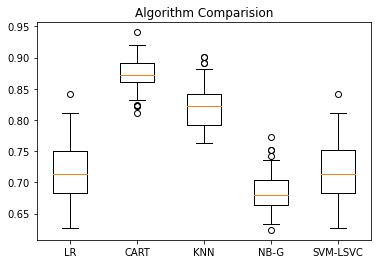

In [37]:
plt.boxplot(results, labels = names, notch = False, vert = True, whis = True)
plt.title("Algorithm Comparision")
plt.show()

##### As observed above, the Decision Tree is observed to be the best model with highest accuracy and least variation. Since the dataset is imbalanced dataset, we will further analyse each models based on recall and F1 score.

In [2]:
# Make predictions on validation dataset
model = LogisticRegression(solver = "liblinear", multi_class = "auto")

# model = LogisticRegression()
model.fit(X_train_res, Y_train_res)
predictions = model.predict(X_test)

# Evaluate predictions
print("Logistic Regression")
print(accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

NameError: name 'LogisticRegression' is not defined

In [39]:
# Make predictions on validation dataset
model = DecisionTreeClassifier(criterion = "gini", splitter = "best", 
                               max_depth = None, min_samples_split = 2, min_samples_leaf = 1)

# model = DecisionTreeClassifier()
model.fit(X_train_res, Y_train_res)
predictions = model.predict(X_test)

# Evaluate predictions
print("Decision Tree Classifier")
print(accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

Decision Tree Classifier
0.8648947951273532
[[773  95]
 [ 27   8]]
              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93       868
         1.0       0.08      0.23      0.12        35

    accuracy                           0.86       903
   macro avg       0.52      0.56      0.52       903
weighted avg       0.93      0.86      0.90       903



In [40]:
# Make predictions on validation dataset
model = KNeighborsClassifier(n_neighbors = 5, weights = "uniform", algorithm = "auto",
                                leaf_size = 30, p = 2, metric = "minkowski")

# model = KNN()
model.fit(X_train_res, Y_train_res)
predictions = model.predict(X_test)

# Evaluate predictions
print("K-Neighbors Classifier")
print(accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

K-Neighbors Classifier
0.7353266888150609
[[649 219]
 [ 20  15]]
              precision    recall  f1-score   support

         0.0       0.97      0.75      0.84       868
         1.0       0.06      0.43      0.11        35

    accuracy                           0.74       903
   macro avg       0.52      0.59      0.48       903
weighted avg       0.93      0.74      0.82       903



In [41]:
# Make predictions on validation dataset
model = GaussianNB()

# model = GaussianNB()
model.fit(X_train_res, Y_train_res)
predictions = model.predict(X_test)

# Evaluate predictions
print("Gaussian Naïve Bayes Classifier")
print(accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

Gaussian Naïve Bayes Classifier
0.5370985603543743
[[457 411]
 [  7  28]]
              precision    recall  f1-score   support

         0.0       0.98      0.53      0.69       868
         1.0       0.06      0.80      0.12        35

    accuracy                           0.54       903
   macro avg       0.52      0.66      0.40       903
weighted avg       0.95      0.54      0.66       903



In [42]:
# Make predictions on validation dataset
model = LinearSVC()

# Model = LinearSVC()
model.fit(X_train_res, Y_train_res)
predictions = model.predict(X_test)

# Evaluate predictions
print("Linear SVC")
print(accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

Linear SVC
0.717607973421927
[[625 243]
 [ 12  23]]
              precision    recall  f1-score   support

         0.0       0.98      0.72      0.83       868
         1.0       0.09      0.66      0.15        35

    accuracy                           0.72       903
   macro avg       0.53      0.69      0.49       903
weighted avg       0.95      0.72      0.80       903



C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


##### Analyzing further based on different parameters - "accuracy", "precision", "recall" and "f1-score", it is observed that the Logistic Regression is the best model. We will use this algorithm for further improvement possibility and analysis.

##### In addition, weightage based penalty approach will be investigated to improve on the hyperparameters of the model because of the imbalanced dataset to compare with the SMOTE upsampling method used earlier.

### 2. Assign a larger penalty to wrong predictions from the minority class.

##### As a second option to deal with imbalanced dataset, we are using weights method which mainly assigns penalty to wrong predictions. In our set, label distribution is 1:24 so we can specify weights as inverse of label distribution. For majority class, will use weight of 1 and for minority class, will use weight of 24. So the penalty of wrong prediction of minority class would be 24 times more severe than wrong prediction of majority class. Moreover, with this class-weight values, we would expect our model to perform better then the default one i.e. previous model.

In [43]:
# Define model
logreg1 = LogisticRegression(random_state = 13, class_weight = None)

# Fit the model
logreg1.fit(X_train,Y_train)

# Test the model
Y_pred = logreg1.predict(X_test)

# Evaluate predictions
print("Logistic Regression before SMOTE")
print(f'Accuracy Score: {accuracy_score(Y_test, Y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(Y_test, Y_pred)}')
print(classification_report(Y_test, Y_pred))
print(f'Area Under Curve: {roc_auc_score(Y_test, Y_pred)}')
print(f'Recall score: {recall_score(Y_test, Y_pred)}')

Logistic Regression before SMOTE
Accuracy Score: 0.9612403100775194
Confusion Matrix: 
[[868   0]
 [ 35   0]]
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       868
         1.0       0.00      0.00      0.00        35

    accuracy                           0.96       903
   macro avg       0.48      0.50      0.49       903
weighted avg       0.92      0.96      0.94       903

Area Under Curve: 0.5
Recall score: 0.0


C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
# Define class weights
w = {0:1, 1:99}

# Defining the model
logreg2 = LogisticRegression(random_state=13, class_weight=w)

# Fit the model
logreg2.fit(X_train,Y_train)

# Test the model
Y_pred = logreg2.predict(X_test)

# Evaluate predictions
print(f'Accuracy Score: {accuracy_score(Y_test, Y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(Y_test, Y_pred)}')
print(classification_report(Y_test, Y_pred))
print(f'Area Under Curve: {roc_auc_score(Y_test, Y_pred)}')
print(f'Recall score: {recall_score(Y_test, Y_pred)}')

Accuracy Score: 0.22148394241417496
Confusion Matrix: 
[[167 701]
 [  2  33]]
              precision    recall  f1-score   support

         0.0       0.99      0.19      0.32       868
         1.0       0.04      0.94      0.09        35

    accuracy                           0.22       903
   macro avg       0.52      0.57      0.20       903
weighted avg       0.95      0.22      0.31       903

Area Under Curve: 0.567626728110599
Recall score: 0.9428571428571428


##### Instead of initially defined weigths, list of weights will be considered to evaluate the most optimized hyperparameter to identify the improvement opportunity in the model.

In [45]:
# Define hyperparameters
w = [{0:0.001,1:1.0}, {0:0.001,1:10}, {0:0.001,1:20}, {0:0.001,1:25}, {0:0.001,1:50}, {0:0.001,1:99},
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:20}, {0:0.01,1:25}, {0:0.01,1:50}, {0:0.01,1:99},  
     {0:0.1,1:1.0}, {0:0.1,1:10}, {0:0.1,1:20}, {0:0.1,1:25}, {0:0.1,1:50}, {0:0.1,1:99}, 
     {0:1.0,1:1.0}, {0:1.0,1:10}, {0:1.0,1:20}, {0:1.0,1:25}, {0:1.0,1:50}, {0:1.0,1:99} ]
crange = np.arange(0.5, 20.0, 0.5)
hyperparam_grid = {"class_weight": w,
                   "penalty": ["l1", "l2"],
                   "C": crange,
                   "fit_intercept": [True, False]  }

# logistic model classifier
logreg3 = LogisticRegression(random_state = 13)

# Define evaluation procedure
grid = GridSearchCV(logreg3, hyperparam_grid, scoring = "f1", cv = 100, n_jobs = -1, refit = True)
grid.fit(X,Y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.22142857142857142 with param: {'C': 1.0, 'class_weight': {0: 1.0, 1: 10}, 'fit_intercept': True, 'penalty': 'l2'}


C:\Users\ch065ba\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.07271872        nan ... 0.08348403        nan 0.08500001]
  warnings.warn(


##### As obesrved, 1.0:10 weight ratio is identified as the penalty hyperparameters giving the best "f1 score" among the list of input weights. We will consider these result as input parameters to improve the model performance.

In [46]:
# Define model
logreg3 = LogisticRegression(random_state = 13, C = 1.0, fit_intercept = True, penalty = 'l2', class_weight = {0: 1.0, 1: 10} )

# fit it
logreg3.fit(X_train,Y_train)

# test
Y_pred = logreg3.predict(X_test)

# Evaluate predictions
print("Logistic Regression after Class Weight")
print(f'Accuracy Score: {accuracy_score(Y_test, Y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(Y_test, Y_pred)}')
print(classification_report(Y_test, Y_pred))
print(f'Area Under Curve: {roc_auc_score(Y_test, Y_pred)}')
print(f'Recall score: {recall_score(Y_test, Y_pred)}')

Logistic Regression after Class Weight
Accuracy Score: 0.9114064230343301
Confusion Matrix: 
[[811  57]
 [ 23  12]]
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       868
         1.0       0.17      0.34      0.23        35

    accuracy                           0.91       903
   macro avg       0.57      0.64      0.59       903
weighted avg       0.94      0.91      0.93       903

Area Under Curve: 0.6385944700460829
Recall score: 0.34285714285714286


##### As observed above, the accuracy is observed to be improved compared to initial (without under/over sampled training) dataset and the one observed after SMOTE technique. Since, the "recall" and "f1-score" for label "0" is still low, no further improvement in the model is feasible. Thus, we will consider Logistic Regression model with the above parameters for further analysis.

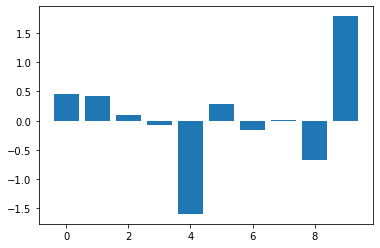

,feature,feature_importance
9,same_address,1.785364
4,pcp_lookback,1.592958
8,same_language,0.670102
0,distance,0.450982
1,visit_count,0.417406
5,family_assignment,0.285215
6,is_ped,0.155418
2,tier,0.089836
3,fqhc,0.072437
7,same_gender,0.018001


In [47]:
# Get importance
importance = logreg3.coef_[0]

# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

features = data_transformed3.drop(["outcome"], axis = 1)

feature_importance = pd.DataFrame({'feature': list(features.columns), 'feature_importance': [abs(i) for i in importance]})
feature_importance.sort_values('feature_importance', ascending = False)

In [48]:
# data_transformed4 = data_transformed3.copy(deep = True)
# data_transformed4 = data_transformed[["outcome", "same_address", "pcp_lookback", "same_language", "distance", "visit_count" ]]

## Recommendations -
#### 1. “pcp_lookback”: If the provider was not the member primary care provider before, it is very likely that the member would opt for a change
#### 2. “same_address”: Out of people who opted for a change, most of them prefer the re-assigned provider to not have same address as the provider pre-assigned
#### 3. “same_language”: If the Provider and member do not speak the same language, it is very likely that the member would request for a change
#### 4. “distance”: This is an intriguing observation, members who stay closer to the provider opt for a change.
#### 5. “visit_count”: If the member visit count is less, then it is very likely that the member would request for a change.